In [59]:
#Version 15.12.12023

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rc

import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime as dt

import os

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

#plt.style.use('uzh')
plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = False

format_k = lambda x, pos: f'{x/10**3:,.0f}K'

plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

def add_terra_and_ftx(ax, which= 'both'):
    if which in ['terra', 'both']:
        terra = ax.axvline(dt.datetime(2022, 5, 7), 0,0.8, color='k', lw = 0.5)
        trans = ax.transData.transform(terra.get_xydata())
        trans = ax.transAxes.inverted().transform(trans)
        terra_text = ax.text(trans[1][0]+0.01,0.6,
                s='Terra Collapse',fontsize = 'xx-small',
                rotation=90, transform=ax.transAxes)
        
    if which in ['ftx', 'both']:
        ftx = ax.axvline(dt.datetime(2022, 11, 2), 0,0.8, color='k', lw = 0.5)
        trans = ax.transData.transform(ftx.get_xydata())
        trans = ax.transAxes.inverted().transform(trans)
        terra_text = ax.text(trans[1][0]+0.01,0.6,
                s='FTX Collapse',fontsize = 'xx-small',
                rotation=90, transform=ax.transAxes)

In [60]:
def transform_to_daily(df, col):
   df = df.copy()
   df = df.sort_index()
   days_ = [str(date) for date in sorted(set(df.index.date.tolist()))]
   df_daily = {}
   for day in days_:
      df_daily[day]={} 
      df_daily[day]['open']=df.loc[day][col][0]
      df_daily[day]['close']=df.loc[day][col][-1]
      df_daily[day]['high']=df.loc[day][col].max()
      df_daily[day]['low']=df.loc[day][col].min()
   df_daily = pd.DataFrame.from_dict(df_daily, orient='index')
   df_daily.index = pd.to_datetime(df_daily.index)
   return df_daily

def hex_to_rgb(value):
    """Return (red, green, blue) for the color given as #rrggbb."""
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv+1, lv // 3))



In [61]:



data = []
cwd = os.getcwd()
for file in os.listdir('data/price'):
   filepath = os.path.join(cwd, 'data/price',file)
   _df = pd.read_csv(filepath)
   _df['timestamp']=pd.to_datetime(_df['timestamp'])
   _df=_df.set_index('timestamp')
   _df = transform_to_daily(_df, 'price')
   _df.currency_pair = file.split('.')[0]
   data.append(_df)
   

In [83]:
import os
data = []
cwd = os.getcwd()
xls = pd.ExcelFile('data/xls/LSD Data ETH.xlsx')
tokens = ['wstETH', 'rETH', 'cbETH', 'sfrxETH', 'ankrETH']
#print(xls.sheet_names)
data_eth_xlsx = []
for sheet in ['ETH', 'wstETH', 'rETH', 'cbETH', 'sfrxETH', 'ankrETH']:
    _df = xls.parse(sheet)
    _df.dropna(subset=['Date'], inplace=True)
    _df['Date']=pd.to_datetime(_df['Date'])
    _df=_df.set_index('Date')
    _df.columns = _df.columns.str.lower()
    _df.token = sheet
    data_eth_xlsx.append(_df)
   
_df = pd.read_csv('data/ETH_STORE_DATA.csv')
#_df = xls.parse('ETH-USD')
print(_df.columns)
_df.dropna(subset=['Date'], inplace=True)
_df['Date']=pd.to_datetime(_df['Date'], infer_datetime_format=True)
_df=_df.set_index('Date')
_df.columns = _df.columns.str.lower()
_df.token = 'ETH-interest'
interest =  _df.copy()

result = pd.concat([d.close for d in data_eth_xlsx], axis=1, join="outer", keys= [d.token for d in data_eth_xlsx])

result = result.div(result['ETH'].values,axis=0)
result = result.drop('ETH', axis=1)
interest['daily']=(1+np.array(interest['eth.store'])/100)**(1/365)
interest['daily_accrued']= interest['daily'].cumprod()

#interest['daily_ETH_change']=interest['adj close'].pct_change(1)
#interest['daily_accrued_ETH']= (1+interest['daily_ETH_change']).cumprod()
#interest['monthly_ETH_std'] = interest['daily_ETH_change'].rolling(30).std()
#interest['daily_ETH_std_change'] = interest['monthly_ETH_std'].pct_change(1)

result_with_interest = pd.concat([result, interest.daily], axis=1, join="outer")
result_with_interest.dropna(subset=['wstETH'], inplace=True)
result_with_interest['daily_accrued']= result_with_interest['daily'].cumprod()

_df = result_with_interest.copy()
adjusted_results = result_with_interest.copy()
for col in ['wstETH', 'rETH', 'cbETH', 'sfrxETH', 'ankrETH']:
    adjusted_results[col]= (adjusted_results[col]/_df.loc[(min(_df[_df[col].notnull()].index.tolist()))][col])*_df.loc[(min(_df[_df[col].notnull()].index.tolist()))]['daily_accrued']



Index(['Date', 'ETH.STORE', 'ETH staking % per day', 'ETH compound'], dtype='object')


/var/folders/4r/y8rtkym13fx1wcrtctrv0pp80000gn/T/ipykernel_92715/3463584226.py:21: UserWarning: Parsing '13.12.2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  _df['Date']=pd.to_datetime(_df['Date'], infer_datetime_format=True)
/var/folders/4r/y8rtkym13fx1wcrtctrv0pp80000gn/T/ipykernel_92715/3463584226.py:21: UserWarning: Parsing '14.12.2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  _df['Date']=pd.to_datetime(_df['Date'], infer_datetime_format=True)
/var/folders/4r/y8rtkym13fx1wcrtctrv0pp80000gn/T/ipykernel_92715/3463584226.py:21: UserWarning: Parsing '15.12.2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  _df['Date']=pd.to_datetime(_df['Date'], infer_datetime_format=True)
/var/folders/4r/y8rtkym13fx1wcrtctrv0pp80000gn/T/ipykernel_92715/3463584226.py:21: UserWarning: Parsing '16.12.2020' in DD/MM/YYYY format. Pro

In [63]:

result = pd.concat([d.close for d in data_eth_xlsx], axis=1, join="outer", keys= [d.token for d in data_eth_xlsx])

result = result.div(result['ETH'].values,axis=0)
result = result.drop('ETH', axis=1)
interest['daily']=(1+np.array(interest['eth.store'])/100)**(1/365)
interest['daily_accrued']= interest['daily'].cumprod()

#interest['daily_ETH_change']=interest['adj close'].pct_change(1)
#interest['daily_accrued_ETH']= (1+interest['daily_ETH_change']).cumprod()
#interest['monthly_ETH_std'] = interest['daily_ETH_change'].rolling(30).std()
#interest['daily_ETH_std_change'] = interest['monthly_ETH_std'].pct_change(1)

result_with_interest = pd.concat([result, interest.daily], axis=1, join="outer")
result_with_interest.dropna(subset=['wstETH'], inplace=True)
result_with_interest['daily_accrued']= result_with_interest['daily'].cumprod()

_df = result_with_interest.copy()
adjusted_results = result_with_interest.copy()
for col in ['wstETH', 'rETH', 'cbETH', 'sfrxETH', 'ankrETH']:
    adjusted_results[col]= (adjusted_results[col]/_df.loc[(min(_df[_df[col].notnull()].index.tolist()))][col])*_df.loc[(min(_df[_df[col].notnull()].index.tolist()))]['daily_accrued']


    


In [66]:
result_with_interest

,wstETH,rETH,cbETH,sfrxETH,ankrETH,daily,daily_accrued
Date,,,,,,,
2021-10-07,1.050049,NaN,NaN,NaN,NaN,1.000175,1.000175
2021-10-08,1.044903,NaN,NaN,NaN,NaN,1.000166,1.000341
2021-10-09,1.045851,NaN,NaN,NaN,NaN,1.000156,1.000497
2021-10-10,1.058360,NaN,NaN,NaN,NaN,1.000150,1.000647
2021-10-11,1.031851,NaN,NaN,NaN,NaN,1.000149,1.000797
...,...,...,...,...,...,...,...
2023-11-29,1.148151,1.092747,1.055055,1.064905,1.136914,1.000105,1.108226
2023-11-30,1.146087,1.090070,1.055630,1.065708,1.138457,1.000105,1.108343
2023-12-01,1.148664,1.096905,1.056685,1.065537,1.139745,1.000136,1.108494


In [67]:
_df = result_with_interest.copy()
adjusted_results = result_with_interest.copy()
for col in ['wstETH', 'rETH', 'cbETH', 'sfrxETH', 'ankrETH']:
    adjusted_results[col]= (adjusted_results[col]/_df.loc[(min(_df[_df[col].notnull()].index.tolist()))][col])*_df.loc[(min(_df[_df[col].notnull()].index.tolist()))]['daily_accrued']


    

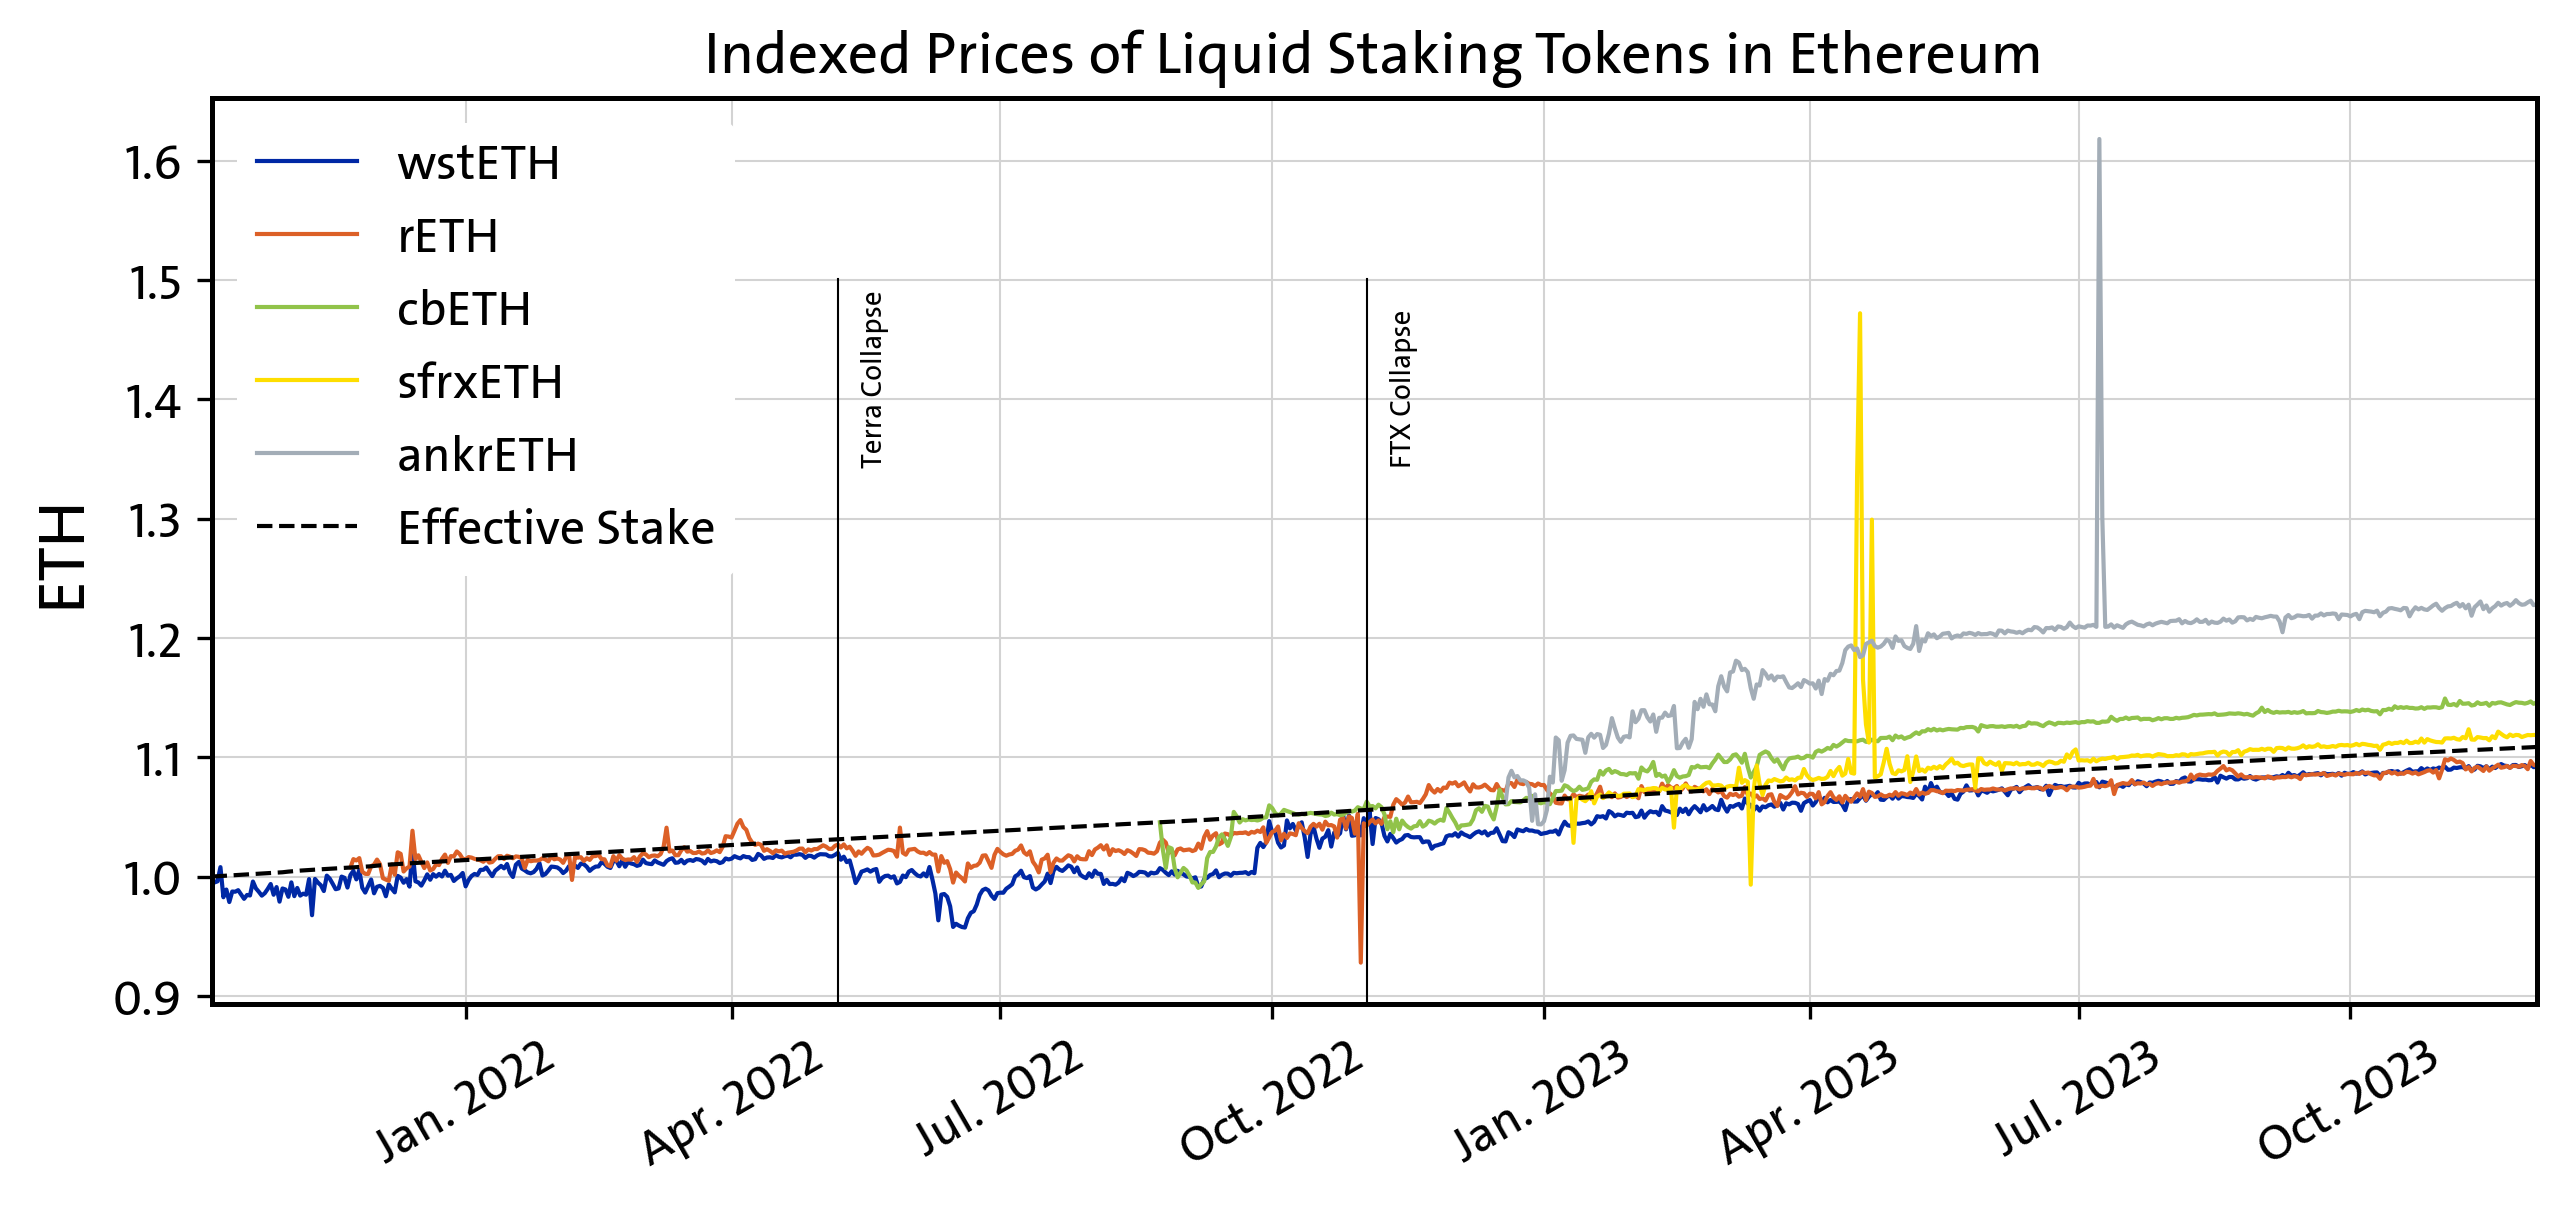

In [68]:
data_to_plot = adjusted_results
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,4),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    ax.plot(data_to_plot.index, data_to_plot[col], lw=1, label = col)

ax.plot(data_to_plot.index, data_to_plot['daily_accrued'], color = 'k', lw=1, ls='--', label='Effective Stake')




ax.set_xlim(min(data_to_plot.index), max(data_to_plot.index))
ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')

add_terra_and_ftx(ax, 'both')

ax.set_title('Indexed Prices of Liquid Staking Tokens in Ethereum')
ax.set_ylabel('ETH')

leg = ax.legend(frameon=True,facecolor='white', framealpha=1)
frame = leg.get_frame()
frame.set_linewidth(0)

# Text in the x-axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b. %Y'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='center')

fig.set_facecolor('w')

In [69]:
df1 =  adjusted_results

In [24]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(df1['rETH'].pct_change(1),order=(2,1,3))
model_results=model.fit()
model_results.summary()

/Users/bekra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bekra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   rETH   No. Observations:                  788
Model:                 ARIMA(2, 1, 3)   Log Likelihood                2632.251
Date:                Fri, 15 Dec 2023   AIC                          -5252.502
Time:                        09:32:18   BIC                          -5224.493
Sample:                    10-07-2021   HQIC                         -5241.734
                         - 12-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4276      0.043    -33.435      0.000      -1.511      -1.344
ar.L2         -0.6644      0.023    -29.146      0.000      -0.709      -0.620
ma.L1         -0.1120      0.044     -2.540      0.011      -0.199      -0.026
ma.L2         -0.6855      0.055    -12.530      0.000      -0.793      -0.578
ma.L3         -0.1405      0.043     -3.277      0.001      -0.225      -0.056
sigma2      4.573e-05   4.16e-07    109.910      0.000    4.49e-05    4.65e-05
===================================================================================
Ljung-Box (L1) (Q):                   4.92   Jarque-Bera (JB):            456298.64
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -3.39
Prob(H) (two-sided):                  0.00   Kurtosis:                       120.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
from scipy import signal
#detrended = signal.detrend(df['Number of Passengers'].values)


data_to_plot = adjusted_results


In [71]:
adjusted_results 

,wstETH,rETH,cbETH,sfrxETH,ankrETH,daily,daily_accrued
Date,,,,,,,
2021-10-07,1.000175,NaN,NaN,NaN,NaN,1.000175,1.000175
2021-10-08,0.995274,NaN,NaN,NaN,NaN,1.000166,1.000341
2021-10-09,0.996177,NaN,NaN,NaN,NaN,1.000156,1.000497
2021-10-10,1.008092,NaN,NaN,NaN,NaN,1.000150,1.000647
2021-10-11,0.982842,NaN,NaN,NaN,NaN,1.000149,1.000797
...,...,...,...,...,...,...,...
2023-11-29,1.093617,1.092859,1.145135,1.117965,1.228268,1.000105,1.108226
2023-11-30,1.091652,1.090181,1.145760,1.118807,1.229934,1.000105,1.108343
2023-12-01,1.094107,1.097016,1.146905,1.118628,1.231326,1.000136,1.108494


In [72]:
_df = adjusted_results.copy()
excess_returns = adjusted_results.copy()
excess_returns['daily']=_df['daily']-1
for col in ['wstETH', 'rETH', 'cbETH', 'sfrxETH', 'ankrETH']:
    excess_returns[col] = _df[col].pct_change(1)

for col in ['wstETH', 'rETH', 'cbETH', 'sfrxETH', 'ankrETH']:
    excess_returns[col] =  excess_returns[excess_returns[col].notna()][col]-excess_returns['daily']



    

In [73]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
_df = adjusted_results.copy()
ret_diff = adjusted_results.copy()
ret_diff['daily']=_df['daily']-1




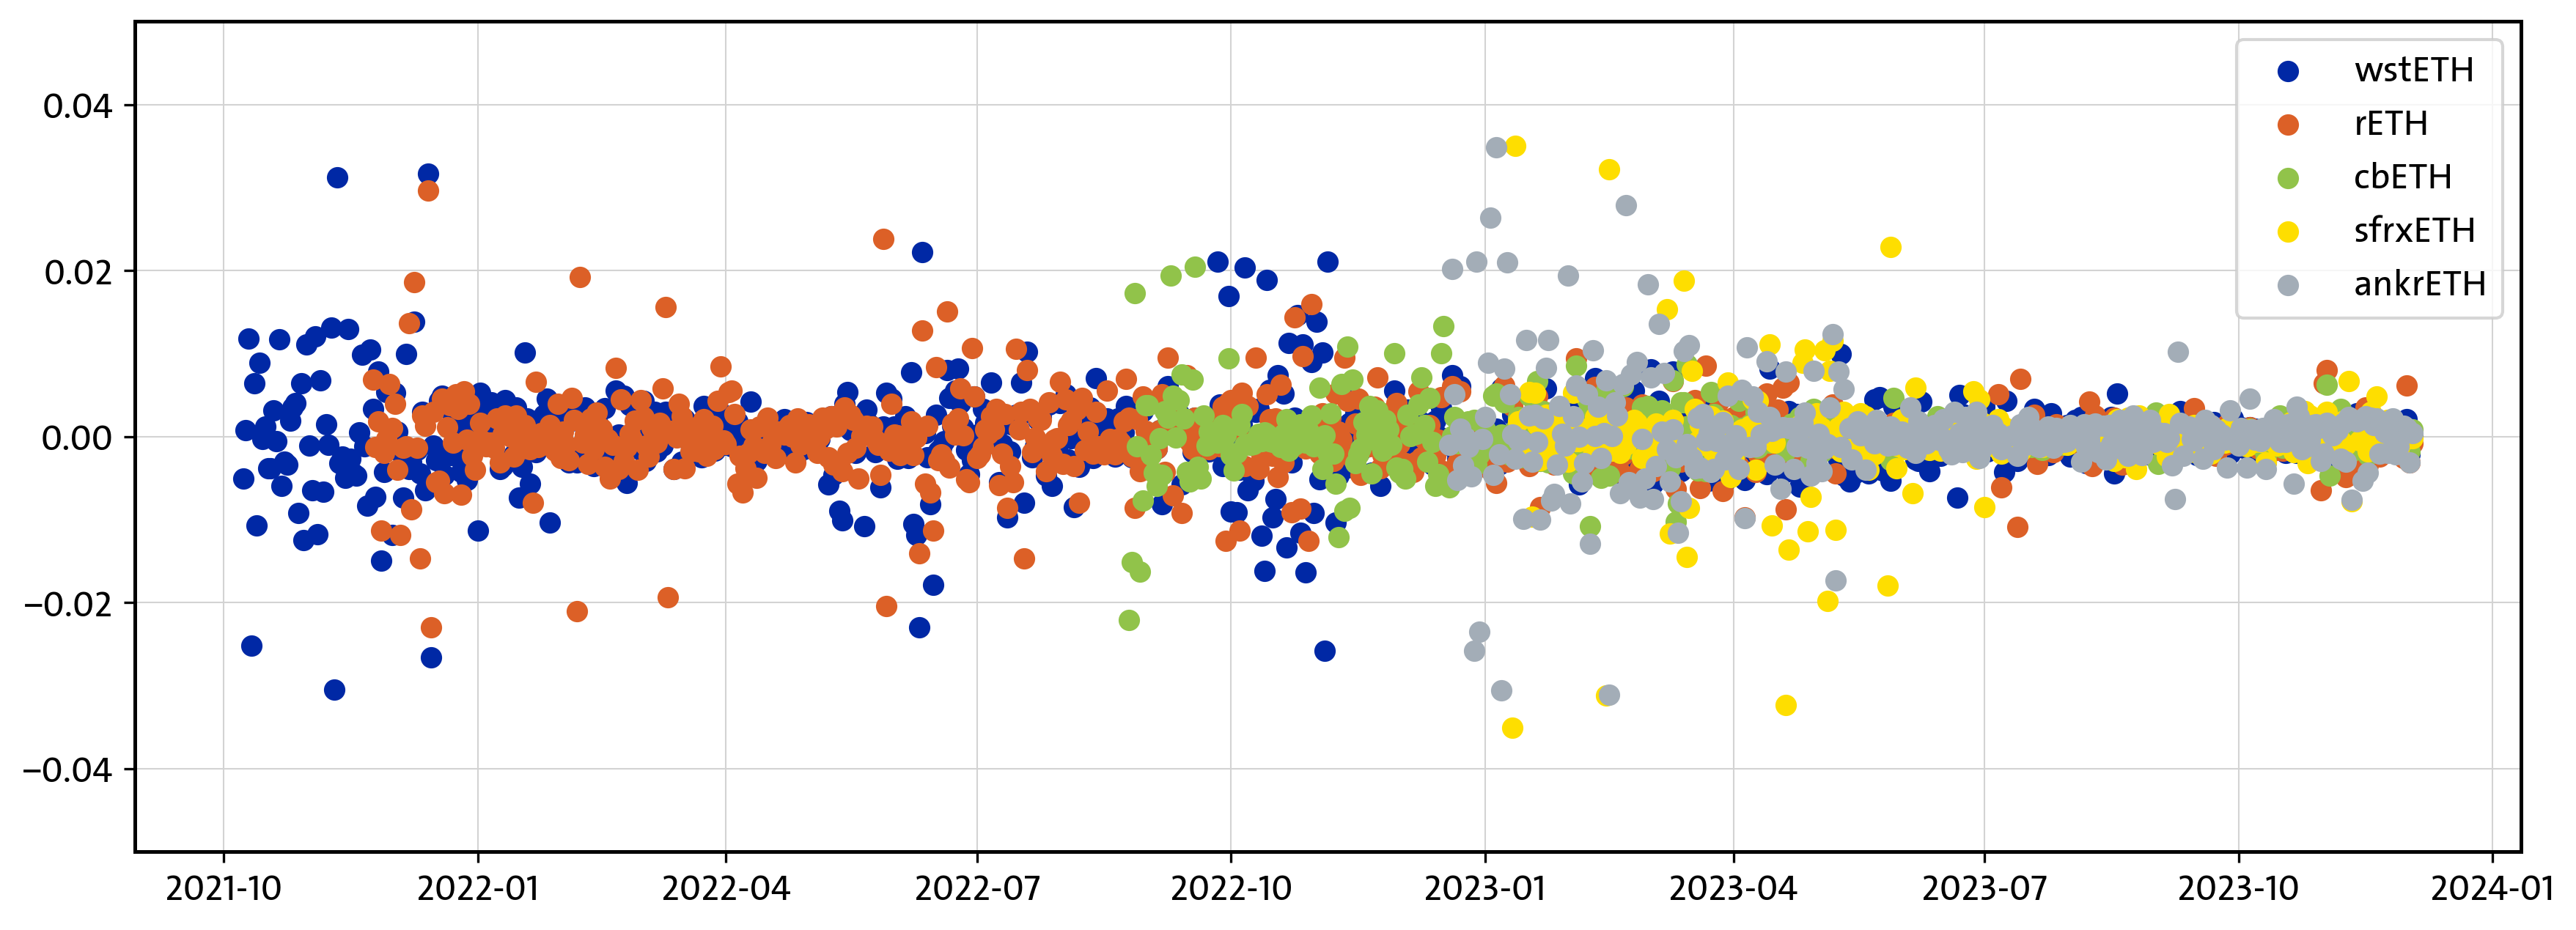

In [74]:
from scipy import signal
#detrended = signal.detrend(df['Number of Passengers'].values)


data_to_plot = excess_returns
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    ax.scatter(data_to_plot[col].index, data_to_plot[col], lw=1, label = col)

#ax.plot(data_to_plot.index, data_to_plot['daily_accrued'], lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
ax.set_ylim(-0.05,0.05)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

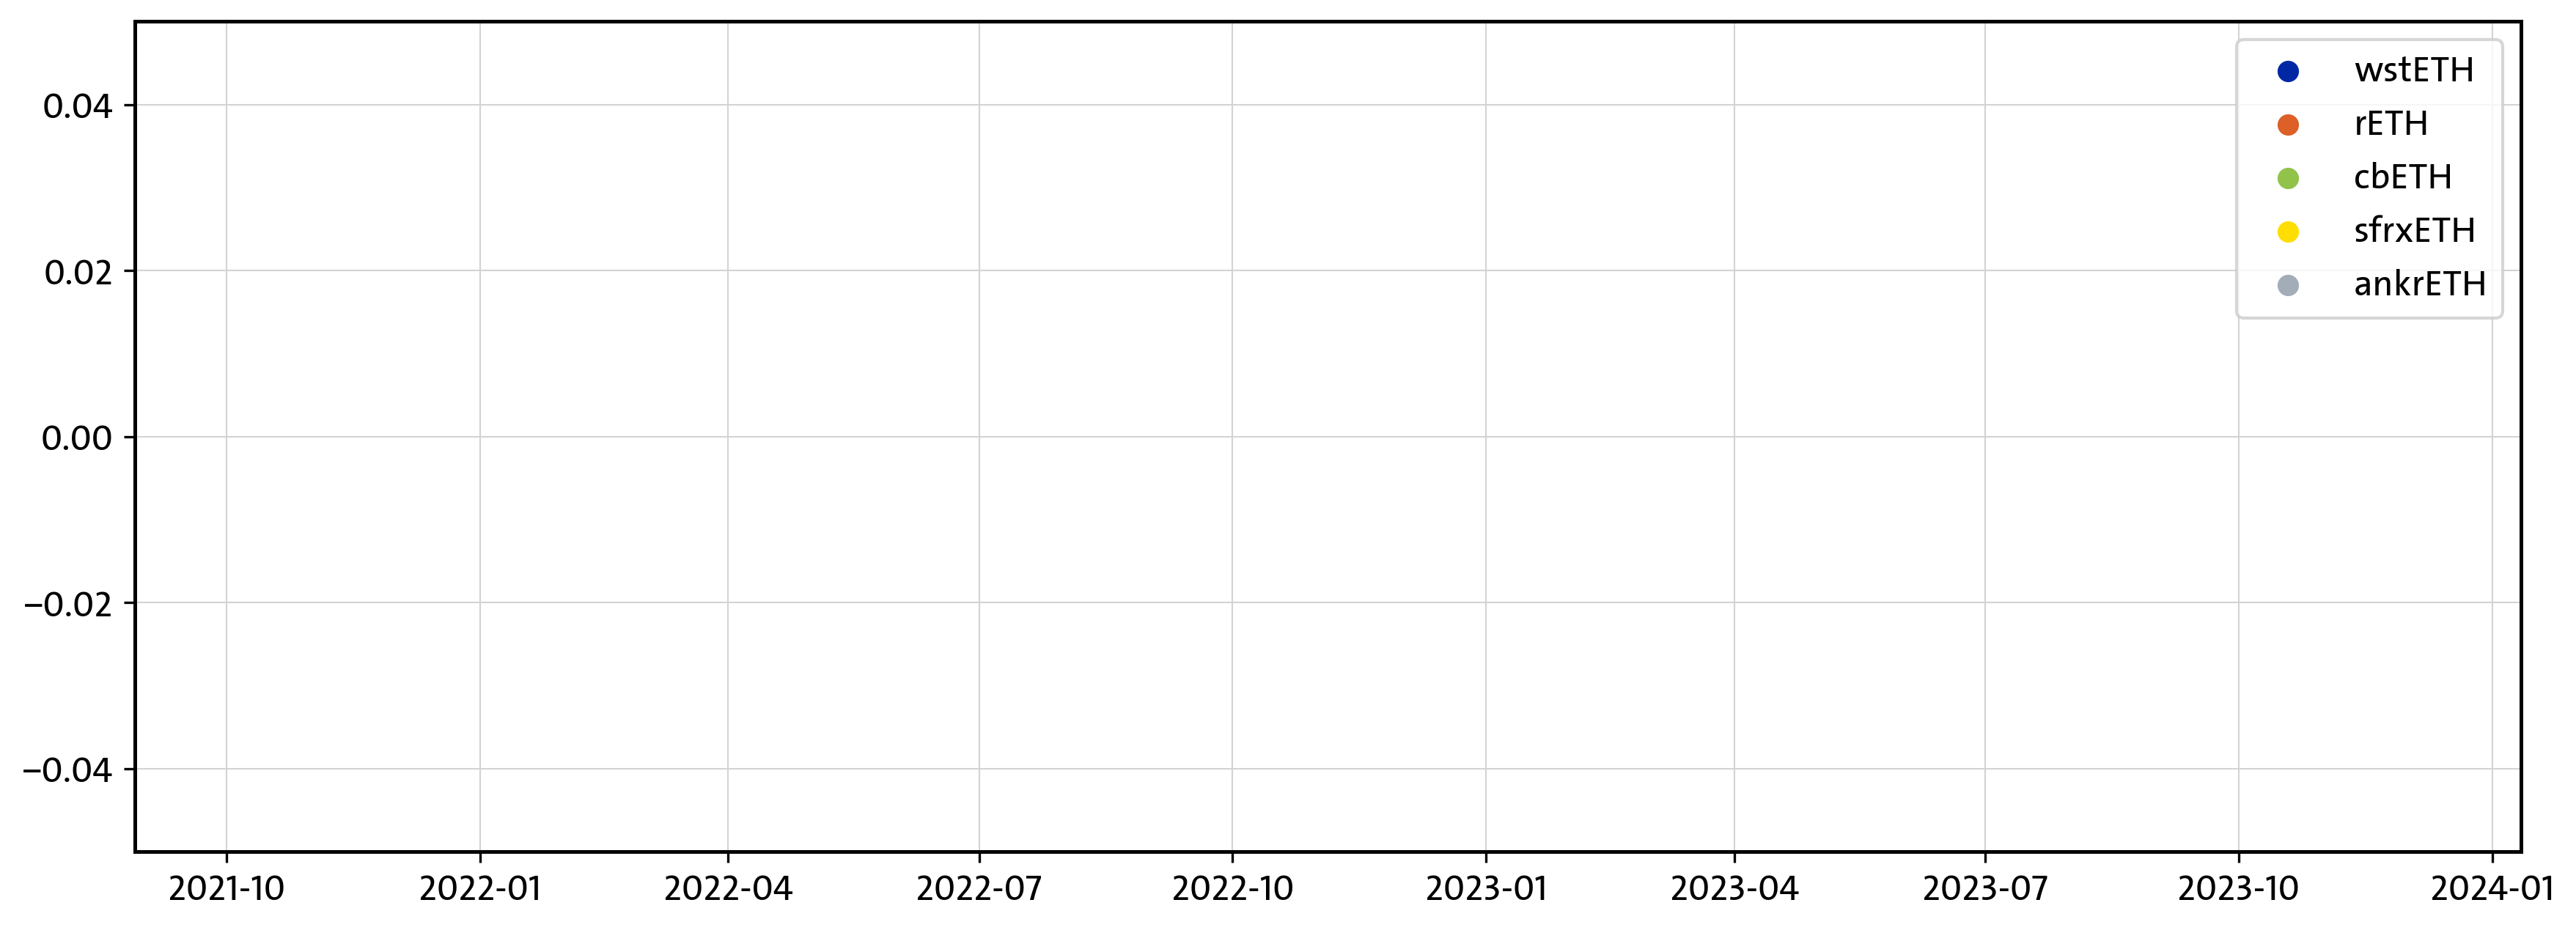

In [31]:
from scipy import signal
#detrended = signal.detrend(df['Number of Passengers'].values)


data_to_plot = ret_diff
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    ax.scatter(data_to_plot[col].index, data_to_plot[col], lw=1, label = col)

#ax.plot(data_to_plot.index, data_to_plot['daily_accrued'], lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
ax.set_ylim(-0.05,0.05)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

In [75]:
excess_returns.describe()

,wstETH,rETH,cbETH,sfrxETH,ankrETH,daily,daily_accrued
count,779.000000,732.000000,458.000000,319.000000,342.000000,780.000000,780.000000
mean,-0.000020,-0.000003,0.000058,0.000329,0.000490,0.000132,1.055843
std,0.005091,0.007694,0.003472,0.024153,0.022336,0.000022,0.031364
min,-0.030463,-0.118650,-0.022145,-0.208735,-0.196038,0.000091,1.000175
25%,-0.001905,-0.001687,-0.000968,-0.001041,-0.001507,0.000120,1.029168
50%,-0.000013,-0.000092,-0.000048,-0.000015,0.000051,0.000131,1.055798
75%,0.001905,0.001534,0.000882,0.001145,0.001500,0.000143,1.083298
max,0.031622,0.125666,0.020450,0.229803,0.337862,0.000303,1.108825


In [78]:
from scipy import signal
#detrended = signal.detrend(df['Number of Passengers'].values)


data_to_plot = excess_returns

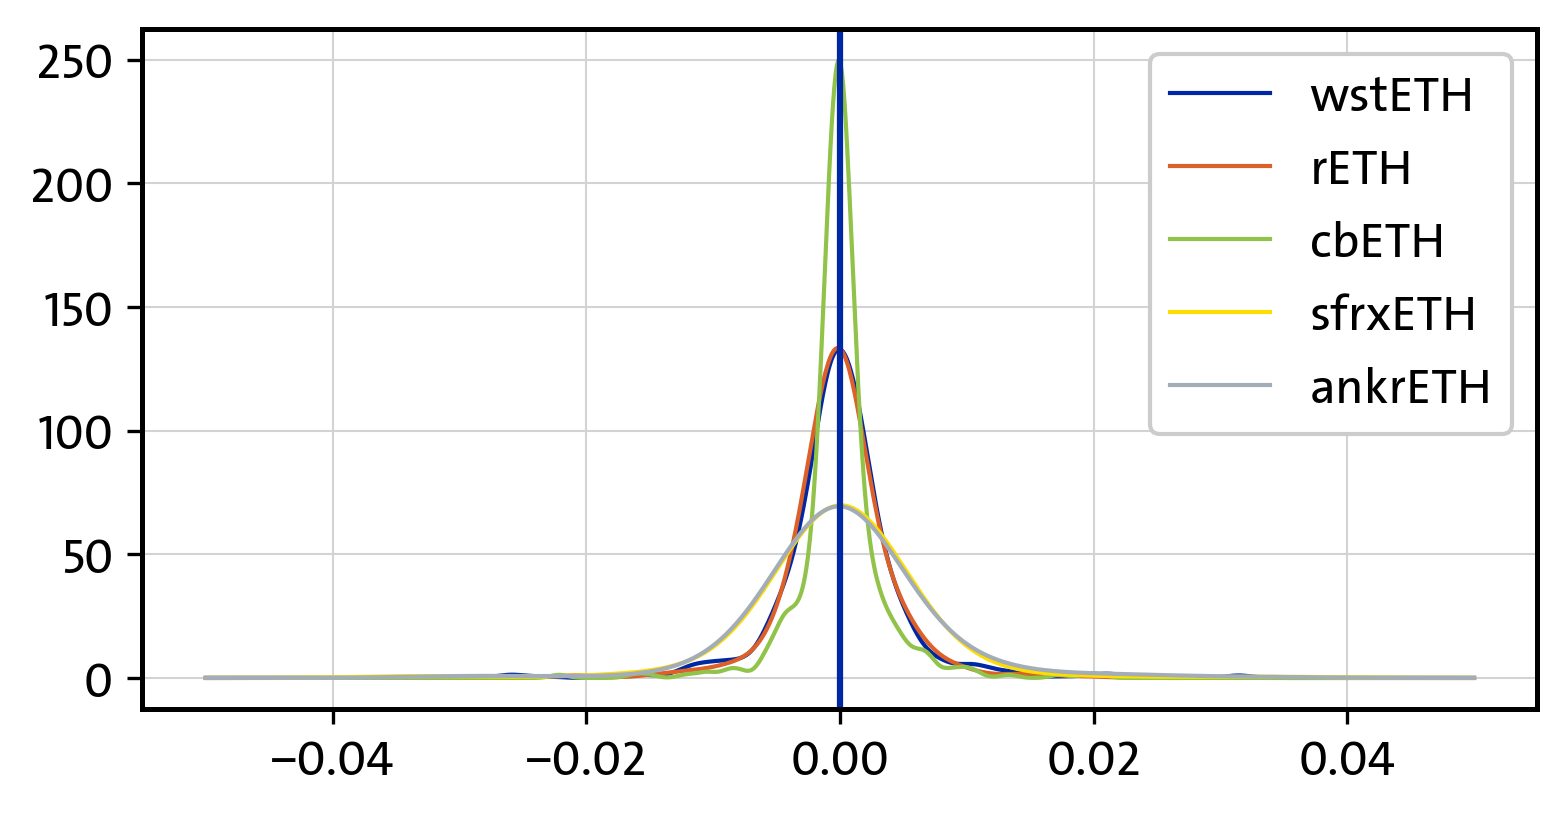

In [82]:
from scipy.stats import gaussian_kde


data_to_plot = excess_returns
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,3),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    d = data_to_plot[data_to_plot[col].notnull()][col].values
    density = gaussian_kde(d)

    density.covariance_factor = lambda : 0.2
    density._compute_covariance()
    x = np.linspace(-0.05,0.05,1000)
    
    line = ax.plot(x,density(x),lw=1, label=col)
    #ax.fill_between(x,0,density(x), alpha = 0.1, color = line[0].get_color())

ax.axvline(0)
ax.set_axisbelow(True)
leg = ax.legend(frameon=True,facecolor='white', framealpha=1)
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')